# Project Predictive Analytics : Users vs Bots Classification
- **Nama:** Hafizha Aghnia Hasya
- **Email:** mc006d5x2114@student.devacademy.id
- **ID Dicoding:** MC006D5X2114

## Import Library

In [1]:
import os
import shutil
import stat
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
# download dataset dari kaggle

kaggle_json_path = "kaggle.json"

kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

shutil.move(kaggle_json_path, os.path.join(kaggle_dir, "kaggle.json"))

kaggle_json_file = os.path.join(kaggle_dir, "kaggle.json")
try:
    os.chmod(kaggle_json_file, stat.S_IRUSR | stat.S_IWUSR)
except Exception as e:
    print("Permission warning (ignore on Windows):", e)

In [3]:
!kaggle datasets download -d juice0lover/users-vs-bots-classification

# fungsi untuk ekstrak file zip
def unzip_file(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted: {zip_path}")

# ekstrak dataset
unzip_file("users-vs-bots-classification.zip")

Dataset URL: https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification
License(s): MIT

Extracted: users-vs-bots-classification.zip



  0%|          | 0.00/110k [00:00<?, ?B/s]
100%|##########| 110k/110k [00:00<00:00, 74.4MB/s]


In [4]:
# hapus file zip
if os.path.exists("users-vs-bots-classification.zip"):
    os.remove("users-vs-bots-classification.zip")

In [5]:
df = pd.read_csv('bots_vs_users.csv')
df.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown


## Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   object 
 1   has_birth_date              5874 non-null   object 
 2   has_photo                   5874 non-null   object 
 3   can_post_on_wall            5874 non-null   object 
 4   can_send_message            5874 non-null   object 
 5   has_website                 5874 non-null   object 
 6   gender                      5874 non-null   object 
 7   has_short_name              5874 non-null   object 
 8   has_first_name              5874 non-null   object 
 9   has_last_name               5874 non-null   object 
 10  access_to_closed_profile    5874 non-null   object 
 11  is_profile_closed           5874 non-null   object 
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

In [7]:
# cek duplikat
print(f'Banyak data yang duplikat : {df.duplicated().sum()} \n')

# cek missing value
missing_value_percent = (df.isnull().sum() / len(df)) * 100
print('Data yang memiliki missing value : ')
print(missing_value_percent[missing_value_percent > 0], '\n')

# cek data dengan value 'Unknown'
unknown_percent = (df.apply(lambda col: col.str.lower().eq('unknown').sum() if col.dtypes == 'object' else 0) / len(df)) * 100
print('Jumlah nilai "unknown" di setiap kolom:')
print(unknown_percent[unknown_percent > 0])

Banyak data yang duplikat : 2616 

Data yang memiliki missing value : 
posts_count               76.319374
avg_likes                 76.319374
links_ratio               76.319374
hashtags_ratio            76.319374
avg_keywords              76.319374
avg_text_length           76.319374
attachments_ratio         76.319374
avg_comments              76.319374
reposts_ratio             76.319374
ads_ratio                 76.319374
avg_views                 76.319374
posting_frequency_days    76.319374
phone_numbers_ratio       76.319374
avg_text_uniqueness       76.319374
dtype: float64 

Jumlah nilai "unknown" di setiap kolom:
has_domain                     0.408580
has_birth_date                14.572693
has_photo                      0.408580
can_post_on_wall               0.408580
can_send_message               0.408580
has_website                   12.631937
gender                         0.408580
has_short_name                 0.408580
has_first_name                 0.408580
has_last

In [8]:
# hapus kolom yang tidak banyak memberikan informasi
# kolom-kolom yang memiliki missing value atau unknown lebih dari 75%
cols_to_drop = missing_value_percent[missing_value_percent > 75].index.union(
    unknown_percent[unknown_percent > 75].index
)
# drop kolom dari DataFrame
df = df.drop(columns=cols_to_drop)

print(f'Kolom yang di-drop (>%75 missing/unknown):')
for col in cols_to_drop:
    print(f'- {col}')

Kolom yang di-drop (>%75 missing/unknown):
- ads_ratio
- attachments_ratio
- avg_comments
- avg_keywords
- avg_likes
- avg_text_length
- avg_text_uniqueness
- avg_views
- has_about
- has_activities
- has_books
- has_career
- has_games
- has_hometown
- has_interests
- has_military_service
- has_movies
- has_music
- has_personal_data
- has_quotes
- has_relatives
- has_schools
- has_tv
- has_universities
- hashtags_ratio
- links_ratio
- marital_status
- phone_numbers_ratio
- posting_frequency_days
- posts_count
- reposts_ratio


In [9]:
'''
nilai unknown pada dataset terdapat pada fitur numerik yang merupakan data nominal, di mana nilai hanya berupa label,
kecuali fitur 'city' yang berupa kategorik.
oleh karena itu, 'unknown' akan diisi dengan -1 untuk membedakannya dengan 0 (false)
'''
# mengganti nilai unknown yang tersisa dengan -1 (kecuali fitur city)
df = df.apply(lambda col: col.str.lower().replace('unknown', -1) if col.dtypes == 'object' and col.name != 'city' else col)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   has_domain                  5874 non-null   object
 1   has_birth_date              5874 non-null   object
 2   has_photo                   5874 non-null   object
 3   can_post_on_wall            5874 non-null   object
 4   can_send_message            5874 non-null   object
 5   has_website                 5874 non-null   object
 6   gender                      5874 non-null   object
 7   has_short_name              5874 non-null   object
 8   has_first_name              5874 non-null   object
 9   has_last_name               5874 non-null   object
 10  access_to_closed_profile    5874 non-null   object
 11  is_profile_closed           5874 non-null   object
 12  target                      5874 non-null   int64 
 13  has_nickname                5874 non-null   obje

In [11]:
# konversi tipe data yang seharusnya integer

# list kolom yang ingin dikonversi ke integer (semua kecuali 'city')
cols_to_convert = df.columns.difference(['city'])
# konversi kolom-kolom tersebut ke integer
df[cols_to_convert] = df[cols_to_convert].astype(float)

In [12]:
# hapus duplikat
df = df.drop_duplicates()

In [13]:
# inisialisasi fitur numerik
nums = df.select_dtypes(include=np.number).columns

# hitung korelasi antar fitur numerik
corr_matrix = df[nums].corr().abs()  # pakai abs supaya korelasi negatif juga dihitung
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# fitur yang memiliki korelasi > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Kolom yang akan di-drop karena korelasi tinggi:")
print(to_drop)

# drop fitur dari dataframe
df.drop(columns=to_drop, inplace=True)

Kolom yang akan di-drop karena korelasi tinggi:
['has_short_name', 'has_first_name', 'is_profile_closed', 'is_blacklisted', 'is_confirmed']


In [14]:
# cek duplikat
print(f'Banyak data yang duplikat (after) : {df.duplicated().sum()} \n')

# cek missing value
missing_value_percent_after = (df.isnull().sum() / len(df)) * 100
print('Data yang memiliki missing value (after) : ')
print(missing_value_percent_after[missing_value_percent_after > 0], '\n')

# cek data dengan value 'Unknown'
unknown_percent_after = (df.apply(lambda col: col.str.lower().eq('unknown').sum() if col.dtypes == 'object' else 0) / len(df)) * 100
print('Jumlah nilai "unknown" di setiap kolom (after):')
print(unknown_percent_after[unknown_percent_after > 0], '\n')

# cek fitur dengan korelasi tinggi
nums = df.select_dtypes(include=np.number).columns
corr_matrix = df[nums].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
multicolinearity_features = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Fitur dengan korelasi tinggi:")
print(multicolinearity_features)

Banyak data yang duplikat (after) : 0 

Data yang memiliki missing value (after) : 
Series([], dtype: float64) 

Jumlah nilai "unknown" di setiap kolom (after):
city    18.929016
dtype: float64 

Fitur dengan korelasi tinggi:
[]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3212 entries, 0 to 5873
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  3212 non-null   float64
 1   has_birth_date              3212 non-null   float64
 2   has_photo                   3212 non-null   float64
 3   can_post_on_wall            3212 non-null   float64
 4   can_send_message            3212 non-null   float64
 5   has_website                 3212 non-null   float64
 6   gender                      3212 non-null   float64
 7   has_last_name               3212 non-null   float64
 8   access_to_closed_profile    3212 non-null   float64
 9   target                      3212 non-null   float64
 10  has_nickname                3212 non-null   float64
 11  has_maiden_name             3212 non-null   float64
 12  has_mobile                  3212 non-null   float64
 13  all_posts_visible           3212 non-n

## Exploratory Data Analysis

### Statistics Descriptive

In [16]:
# melihat tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3212 entries, 0 to 5873
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  3212 non-null   float64
 1   has_birth_date              3212 non-null   float64
 2   has_photo                   3212 non-null   float64
 3   can_post_on_wall            3212 non-null   float64
 4   can_send_message            3212 non-null   float64
 5   has_website                 3212 non-null   float64
 6   gender                      3212 non-null   float64
 7   has_last_name               3212 non-null   float64
 8   access_to_closed_profile    3212 non-null   float64
 9   target                      3212 non-null   float64
 10  has_nickname                3212 non-null   float64
 11  has_maiden_name             3212 non-null   float64
 12  has_mobile                  3212 non-null   float64
 13  all_posts_visible           3212 non-n

In [17]:
# fitur numerik
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_domain,3212.0,0.998755,0.049899,-1.0,1.00,1.0,1.0,1.0
has_birth_date,3212.0,0.585928,0.810489,-1.0,1.00,1.0,1.0,1.0
has_photo,3212.0,0.877958,0.329283,-1.0,1.00,1.0,1.0,1.0
can_post_on_wall,3212.0,0.070050,0.257699,-1.0,0.00,0.0,0.0,1.0
can_send_message,3212.0,0.715442,0.452652,-1.0,0.00,1.0,1.0,1.0
has_website,3212.0,0.107098,0.558382,-1.0,0.00,0.0,0.0,1.0
gender,3212.0,1.283313,0.459573,-1.0,1.00,1.0,2.0,2.0
has_last_name,3212.0,0.996887,0.065957,-1.0,1.00,1.0,1.0,1.0
access_to_closed_profile,3212.0,0.883250,0.323105,-1.0,1.00,1.0,1.0,1.0
target,3212.0,0.218867,0.413542,0.0,0.00,0.0,0.0,1.0


In [18]:
# fitur kategorik
df.describe(exclude=np.number)

,city
count,3212
unique,362
top,Saint Petersburg
freq,1240


### Univariate & Multivariate Analysis

In [19]:
# inisialisasi fitur numerik
nums = df.select_dtypes(include=np.number).columns

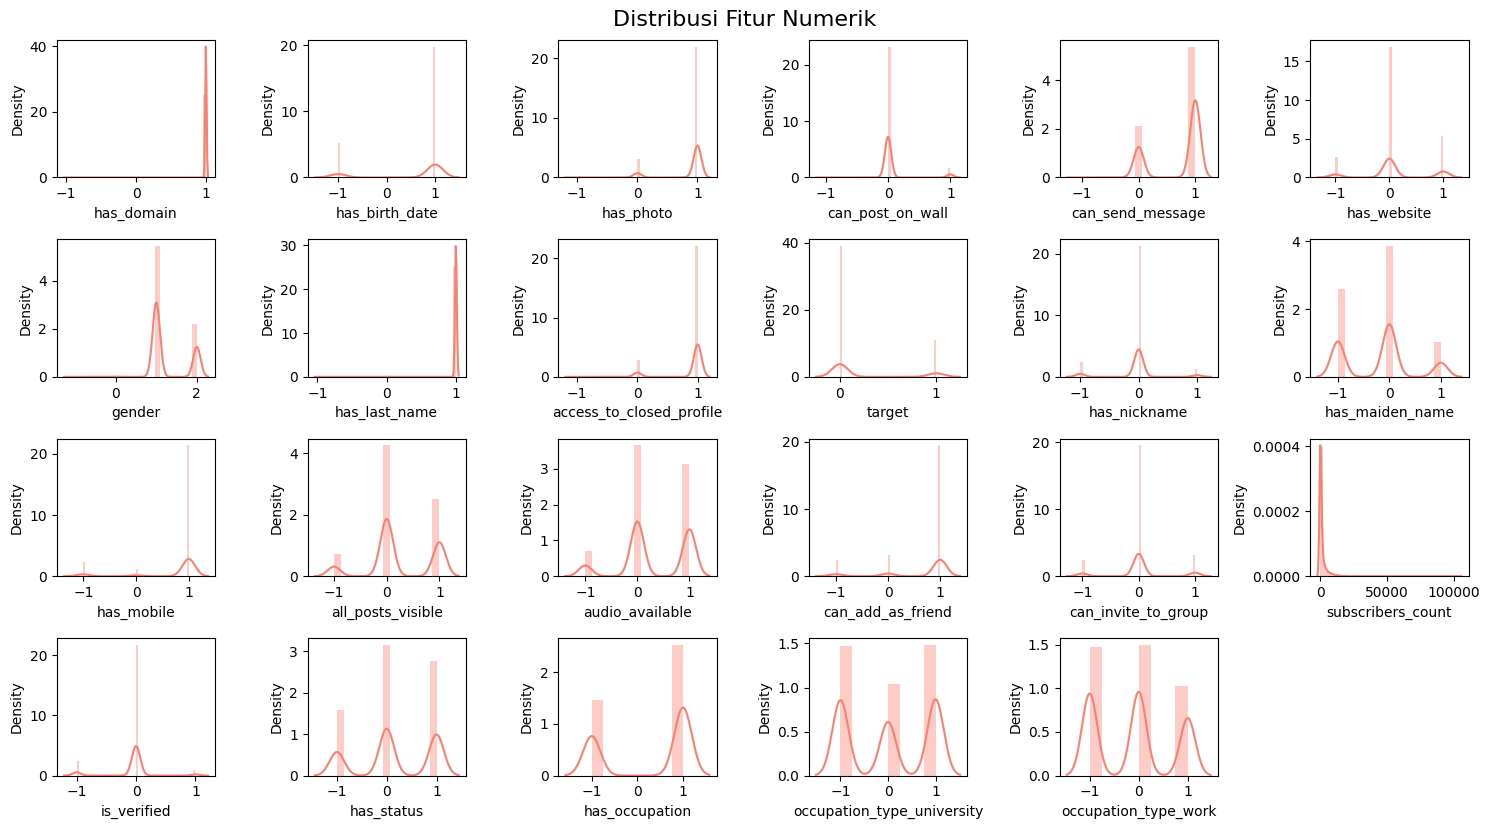

In [20]:
# menampilkan distribusi fitur numerik
fig, axes = plt.subplots(figsize=(15, 10))
fig.suptitle('Distribusi Fitur Numerik', fontsize=16)
for i in range(0, len(nums)):
    plt.subplot(5, 6, i+1)
    sns.distplot(df[nums[i]],color='salmon')
    plt.tight_layout()

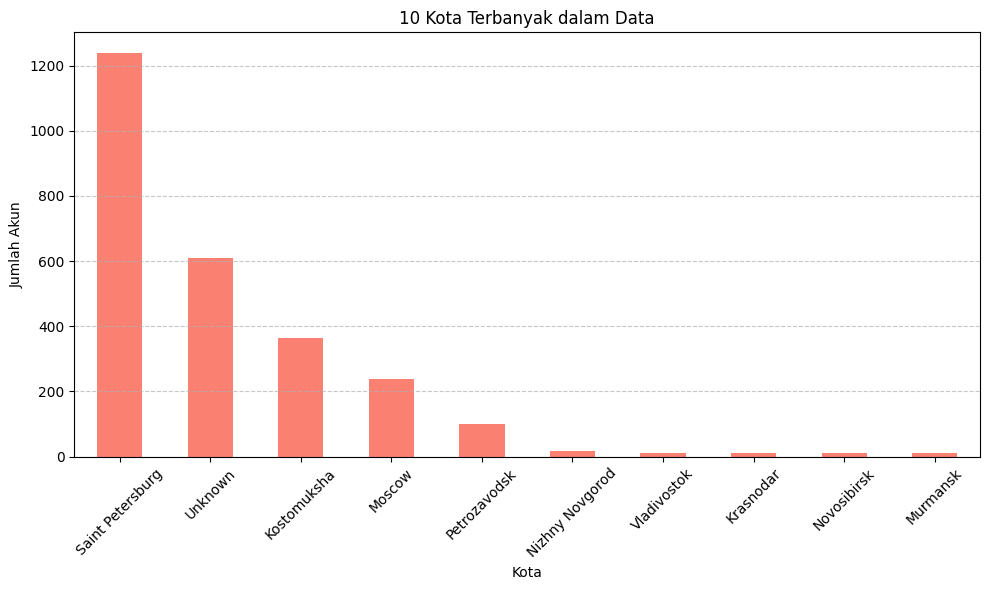

In [21]:
# menampilkan distribusi fitur kategorik (city)

city_counts = df['city'].value_counts()

# ambil 10 kota terbanyak
top10 = city_counts.head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='bar', color='salmon')
plt.title('10 Kota Terbanyak dalam Data')
plt.ylabel('Jumlah Akun')
plt.xlabel('Kota')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


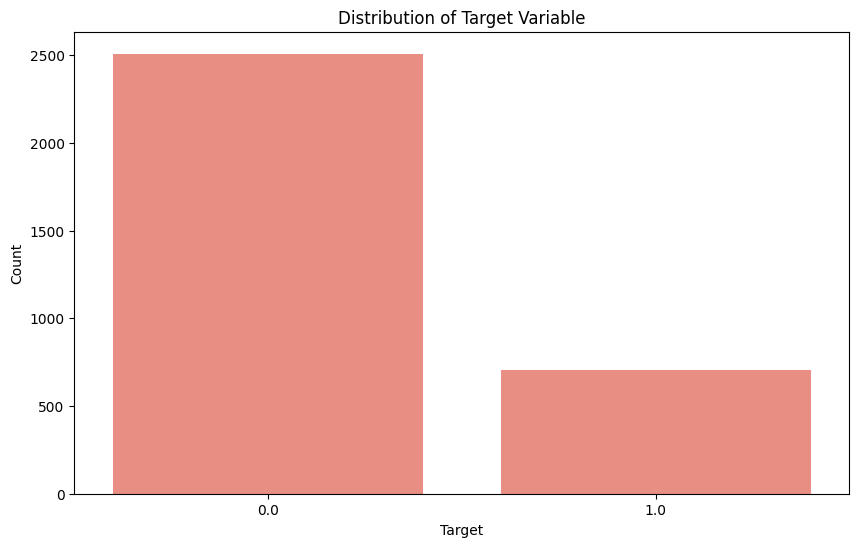

In [22]:
# distribusi fitur target
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, color='salmon')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

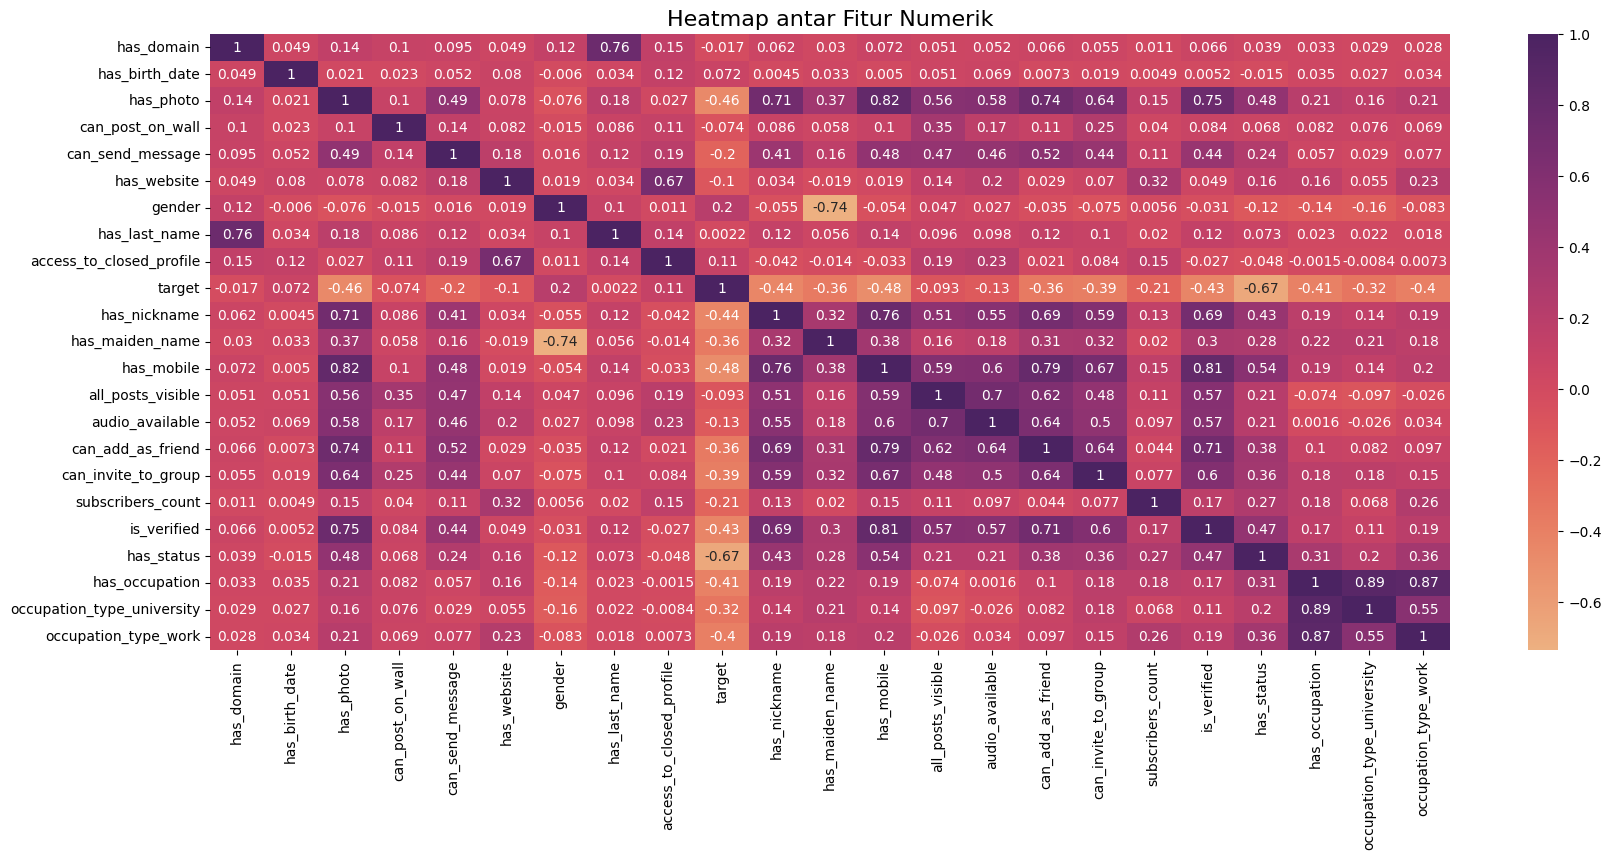

In [23]:
# menampilkan korelasi antar fitur numerik menggunakan heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(df[nums].corr(), cmap='flare', annot=True)
plt.title('Heatmap antar Fitur Numerik', fontsize=16)
plt.show()

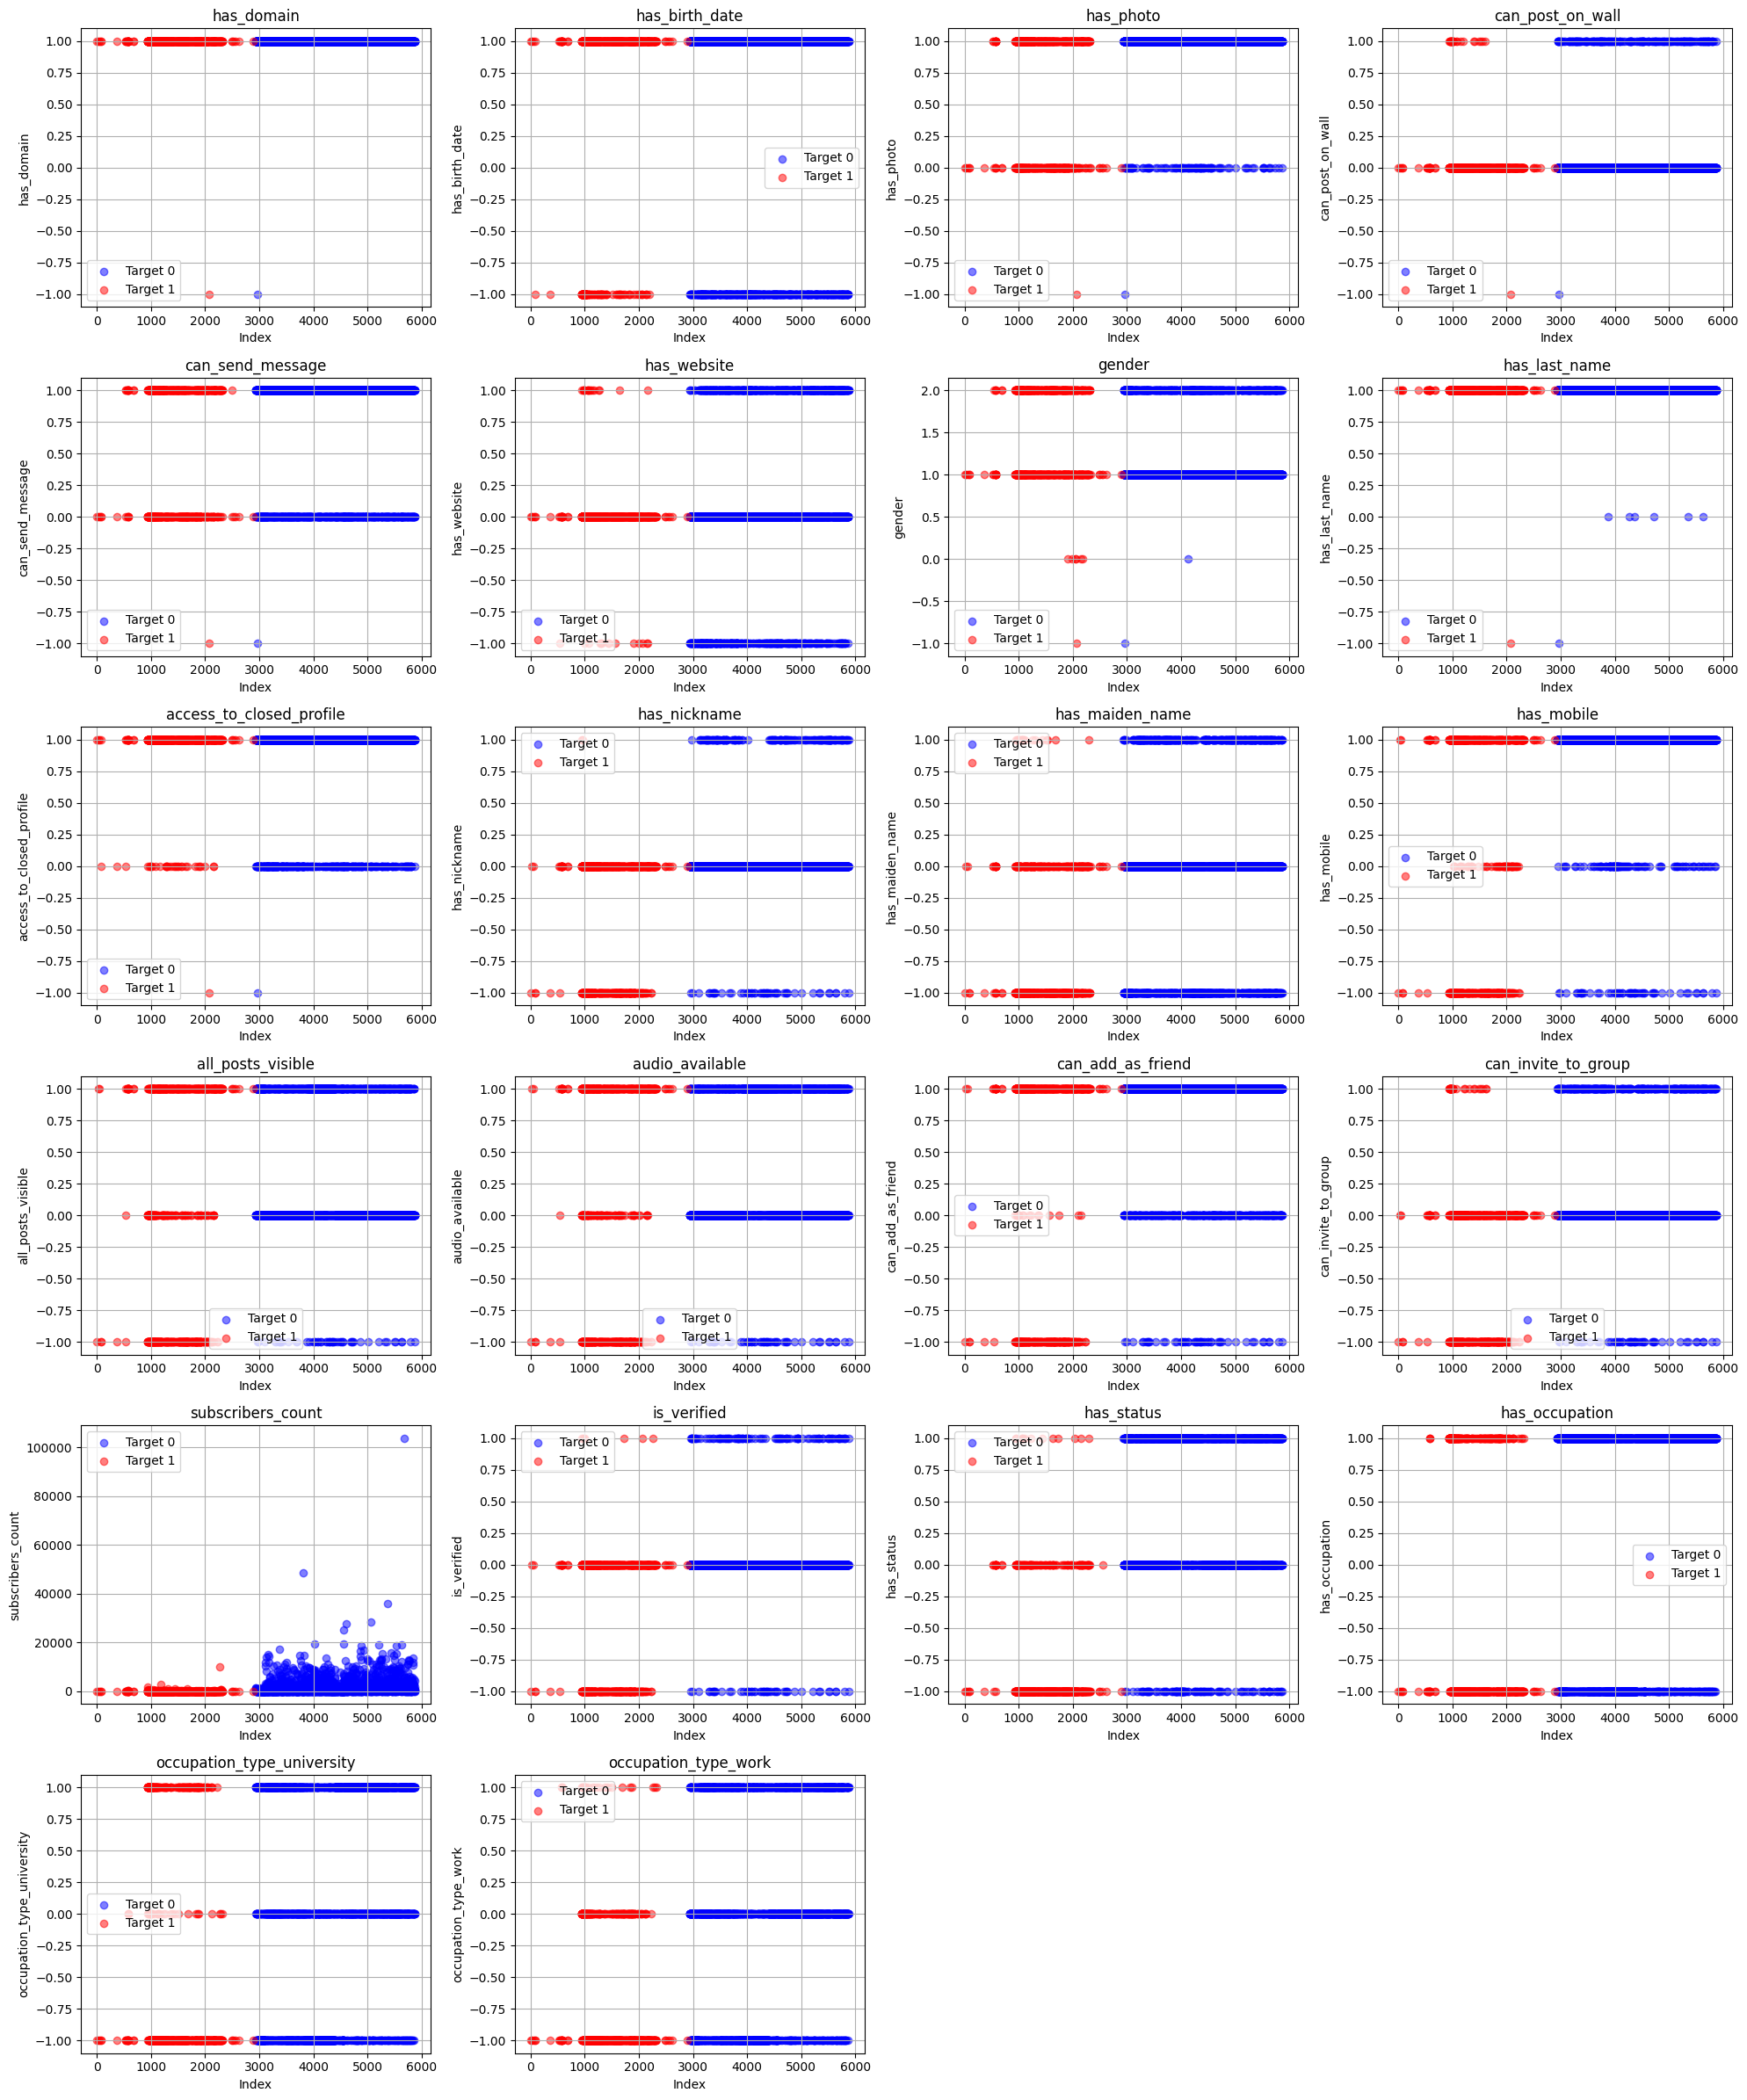

In [24]:
# distribusi fitur numerik terhadap target

nums_no_target = [f for f in nums if f != 'target']

n_cols = 4
n_rows = math.ceil(len(nums_no_target) / n_cols)
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, feature in enumerate(nums_no_target):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(df.index[df['target'] == 0], df[df['target'] == 0][feature],
                color='blue', alpha=0.5, label='Target 0')
    plt.scatter(df.index[df['target'] == 1], df[df['target'] == 1][feature],
                color='red', alpha=0.5, label='Target 1')
    plt.title(feature)
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

## Data Preparation

### Feature Encoding

In [25]:
# mengubah data kategrorik menjadi numerik menggunakan label encoding

label_encoder = LabelEncoder()
# melakukan encoding untuk fitur city
df['city'] = label_encoder.fit_transform(df['city'])
df.head(2)

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_last_name,access_to_closed_profile,target,...,audio_available,can_add_as_friend,can_invite_to_group,subscribers_count,is_verified,has_status,city,has_occupation,occupation_type_university,occupation_type_work
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,319,-1.0,-1.0,-1.0
27,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,23.0,0.0,-1.0,319,-1.0,-1.0,-1.0


### Split Data

In [26]:
# Split Data Training dan Testing
X = df.drop(['target'], axis = 1)
y = df['target']

# Split data 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [27]:
print(X_train.shape)
print(X_test.shape)

(2569, 23)
(643, 23)


### Handling Class Imbalance

In [28]:
# Initialize SMOTE
smote = SMOTE(random_state=17)

# Doing oversampling to Data Train
X_train_o, y_train_o = smote.fit_resample(X_train, y_train)

In [29]:
print(X_train_o.shape)

(4068, 23)


### Feature Transformation

In [30]:
# standarisasi data
scaler = StandardScaler()
X_train_o = scaler.fit_transform(X_train_o)
X_test = scaler.transform(X_test)

## Modeling

In [31]:
rf = RandomForestClassifier()
xgb = XGBClassifier()
knn = KNeighborsClassifier(n_neighbors=5)

models = [rf, xgb, knn]
results = {}

for model in models:
    model_name = type(model).__name__
    model.fit(X_train_o, y_train_o)
    y_pred = model.predict(X_test)
    # simpan hasil evaluasi dalam dictionary
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred)
    }
    print(f'{model_name} Finished!')

RandomForestClassifier Finished!
XGBClassifier Finished!
KNeighborsClassifier Finished!


In [32]:
results_df = pd.DataFrame(results).T  # transpose biar model di baris
display(results_df)

,accuracy,precision,recall,f1_score,roc_auc
RandomForestClassifier,0.930016,0.891720,0.833333,0.861538,0.898772
XGBClassifier,0.947123,0.913580,0.880952,0.896970,0.925739
KNeighborsClassifier,0.898911,0.787709,0.839286,0.812680,0.879643


### Hyperparameter Tuning

In [33]:
# parameter grid untuk setiap model
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

# inisialisasi ulang model untuk GridSearchCV
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(eval_metric='logloss'),
    'KNeighborsClassifier': KNeighborsClassifier()
}

# simpan best model dan hasil tuning
best_models = {}
tuned_results = {}

for name, model in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_o, y_train_o)

    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)
    
    # simpan hasil evaluasi model
    tuned_results[name] = {
        'best_params': grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred)
    }
    
    print(f"{name} tuning finished. Best params: {grid.best_params_} \n")

Tuning RandomForestClassifier...
RandomForestClassifier tuning finished. Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300} 

Tuning XGBClassifier...
XGBClassifier tuning finished. Best params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100} 

Tuning KNeighborsClassifier...
KNeighborsClassifier tuning finished. Best params: {'n_neighbors': 3, 'weights': 'distance'} 



## Model Evaluation

In [34]:
pd.DataFrame(tuned_results).T

,best_params,accuracy,precision,recall,f1_score,roc_auc
RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.947123,0.89881,0.89881,0.89881,0.93151
XGBClassifier,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.948678,0.904192,0.89881,0.901493,0.932563
KNeighborsClassifier,"{'n_neighbors': 3, 'weights': 'distance'}",0.88958,0.77095,0.821429,0.795389,0.867556


In [35]:
best_models

{'RandomForestClassifier': RandomForestClassifier(max_depth=10, n_estimators=300),
 'XGBClassifier': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', gamma=0, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.2, max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
               random_state=0, reg_alpha=0, reg_lambda=1, ...),
 'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=3, weights='distance')}